## XGBoost - pair distribution function (PDF) - number of atoms

In [1]:
import numpy as np
import pandas as pd
import h5py
from debyecalculator import DebyeCalculator
from ase.io import read
import glob
import os
import sys
import random
import tiktoken
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/")
from plotutils import *
plt.style.use("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/kevin.mplstyle")

random.seed(42)
np.random.seed(42)

/home/vicky/anaconda3/envs/debyecalculator_env/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
def process_xyz_files():
    # Initialise DebyeCalculator object
    calc = DebyeCalculator()
    print(calc)
    
    # Load XYZ files
    XYZ_files = sorted(glob.glob("../xyz_files/*.xyz"))
    random.shuffle(XYZ_files)

    # Calculate Pair Distribution Function for all XYZ files
    scattering_files = []
    structure_types = []
    num_atoms = []

    for iter, xyz_file in enumerate(XYZ_files):
        # Extract structure type
        structure_type = os.path.basename(xyz_file).split('_')[0]

        # Calculate the scattering pattern
        scatt_x, scatt_Int = calc.gr(structure_source=xyz_file)

        # Normalise the scattering files
        scatt_Int /= max(scatt_Int)
        scattering_files.append(scatt_Int)

        # Increment the count for this structure type
        structure_types.append(structure_type)

        atoms = read(xyz_file)
        num_atoms.append(len(atoms))

    return scattering_files, structure_types, num_atoms

In [3]:
# Simulate scattering data
scattering_files, structure_types, num_atoms = process_xyz_files()

/tmp/ipykernel_12845/1612413307.py:3: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled CPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator()


DebyeCalculator{'qmin': 1.0, 'qmax': 30.0, 'qdamp': 0.04, 'qstep': 0.05, 'rmin': 0.0, 'rmax': 20.0, 'rstep': 0.01, 'rthres': 0.0, 'biso': 0.3}


In [4]:
len(scattering_files[0])

2000

In [5]:
np.set_printoptions(threshold=sys.maxsize)

In [6]:
scattering_files[0]

array([ 0.00000000e+00, -1.24081259e-03, -2.43981788e-03, -3.55886901e-03,
       -4.56686504e-03, -5.44242794e-03, -6.17583841e-03, -6.76981779e-03,
       -7.23938225e-03, -7.61045050e-03, -7.91762862e-03, -8.20107665e-03,
       -8.50310456e-03, -8.86432454e-03, -9.32015758e-03, -9.89775546e-03,
       -1.06134415e-02, -1.14714708e-02, -1.24634868e-02, -1.35693504e-02,
       -1.47587219e-02, -1.59940217e-02, -1.72333848e-02, -1.84345916e-02,
       -1.95586290e-02, -2.05732044e-02, -2.14555021e-02, -2.21943278e-02,
       -2.27909349e-02, -2.32591350e-02, -2.36239322e-02, -2.39193980e-02,
       -2.41856966e-02, -2.44655330e-02, -2.48004626e-02, -2.52271071e-02,
       -2.57741194e-02, -2.64594071e-02, -2.72887163e-02, -2.82550789e-02,
       -2.93392893e-02, -3.05116437e-02, -3.17345411e-02, -3.29658240e-02,
       -3.41622792e-02, -3.52836587e-02, -3.62959877e-02, -3.71749178e-02,
       -3.79074812e-02, -3.84935588e-02, -3.89457569e-02, -3.92884202e-02,
       -3.95554863e-02, -

In [7]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0])))
num_tokens

19524

In [8]:
len(scattering_files[0].round(3)[::15])

134

In [9]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0].round(3)[::15])))
num_tokens

551

### distribution of num of atoms values in the dataset

(array([285., 247., 228., 171., 171., 209., 133., 152., 171., 190.]),
 array([  6. ,  15.4,  24.8,  34.2,  43.6,  53. ,  62.4,  71.8,  81.2,
         90.6, 100. ]),
 <BarContainer object of 10 artists>)

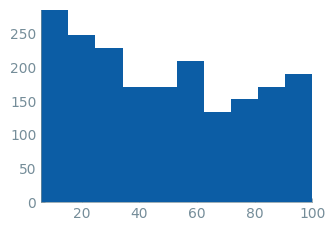

In [10]:
plt.figure(figsize=(3.5, 2.5))
plt.hist(num_atoms)

In [11]:
scattering_patterns = []

In [12]:
for i in np.arange(len(scattering_files)):
    pattern = scattering_files[i].round(3)[::15]
    scattering_patterns.append(pattern)

In [13]:
len(scattering_patterns[0])

134

### prepare regression dataset for number of atoms

In [14]:
scattering_patterns = np.array(scattering_patterns)
num_atoms = np.array(num_atoms)

In [15]:
THRESHOLD_num = 60

In [16]:
num_atoms_binned = np.array([1 if value > THRESHOLD_num else 0 for value in num_atoms])
num_atoms_binned

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,

In [17]:
np.unique(num_atoms_binned, return_counts=True)

(array([0, 1]), array([1311,  646]))

In [18]:
MAX_TEST_DATA = 2000
train_size = 1800

In [19]:
indices = np.arange(len(num_atoms))
indices

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [20]:
train_indices, val_test_indices = train_test_split(
    indices, 
    train_size=train_size, 
    test_size=min(len(indices)-train_size, MAX_TEST_DATA),
    random_state=42,
    stratify=num_atoms_binned
)

In [21]:
len(train_indices)

1800

In [22]:
len(val_test_indices)

157

In [23]:
y_val_test = num_atoms[val_test_indices]

In [24]:
y_val_test_binned = np.array([1 if value > THRESHOLD_num else 0 for value in y_val_test])
y_val_test_binned

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1])

In [25]:
val_indices, test_indices = train_test_split(
    val_test_indices, 
    test_size=0.5, 
    random_state=42,
    stratify=y_val_test_binned
)

In [26]:
len(val_indices)

78

In [27]:
len(test_indices)

79

In [28]:
X_train, y_train = scattering_patterns[train_indices], num_atoms[train_indices]
X_val, y_val = scattering_patterns[val_indices], num_atoms[val_indices]
X_test, y_test = scattering_patterns[test_indices], num_atoms[test_indices]

In [29]:
np.unique(y_train, return_counts=True)

(array([  6,   7,   8,   9,  10,  12,  13,  14,  15,  16,  18,  19,  20,
         23,  24,  25,  27,  28,  29,  30,  32,  33,  35,  36,  39,  40,
         42,  43,  44,  48,  49,  50,  51,  54,  55,  56,  57,  59,  60,
         63,  64,  70,  71,  72,  75,  80,  81,  83,  84,  85,  87,  89,
         90,  93,  95,  96,  98, 100]),
 array([34, 35, 35, 19, 19, 34, 51, 17, 19, 52, 35, 51, 16, 18, 56, 33, 31,
        19, 18, 17, 49, 35, 19, 37, 18, 53, 15, 18, 17, 68, 18, 19, 36, 36,
        34, 37, 37, 18, 33, 35, 52, 18, 18, 52, 15, 55, 19, 18, 35, 36, 36,
        19, 16, 32, 18, 70, 16, 34]))

In [30]:
np.unique(y_val, return_counts=True)

(array([  6,   7,   8,  12,  13,  14,  16,  18,  19,  20,  25,  27,  29,
         30,  32,  33,  36,  40,  42,  43,  44,  48,  49,  51,  54,  55,
         56,  59,  60,  63,  70,  72,  75,  80,  84,  85,  87,  90,  93,
         95,  96,  98, 100]),
 array([3, 1, 1, 3, 3, 1, 2, 1, 1, 2, 2, 3, 1, 2, 3, 3, 1, 1, 1, 1, 1, 3,
        1, 2, 1, 3, 1, 1, 3, 3, 1, 3, 2, 1, 1, 1, 2, 1, 3, 1, 3, 1, 3]))

In [31]:
np.unique(y_test, return_counts=True)

(array([  6,   7,   8,  12,  13,  14,  16,  18,  19,  20,  23,  24,  25,
         27,  32,  39,  40,  42,  44,  48,  54,  55,  57,  60,  64,  71,
         72,  75,  80,  83,  84,  85,  90,  93,  96,  98, 100]),
 array([1, 2, 2, 1, 3, 1, 3, 2, 5, 1, 1, 1, 3, 4, 5, 1, 3, 3, 1, 5, 1, 1,
        1, 2, 5, 1, 2, 2, 1, 1, 2, 1, 2, 3, 3, 2, 1]))

In [32]:
X_train[0]

array([ 0.   , -0.013, -0.023, -0.034, -0.047, -0.057, -0.066, -0.077,
       -0.087, -0.092, -0.101, -0.111, -0.114, -0.115, -0.124, -0.045,
        0.838,  0.499, -0.101, -0.133, -0.126, -0.119, -0.096,  0.086,
       -0.021, -0.098, -0.026,  0.105,  0.108, -0.014, -0.063,  0.069,
        0.038, -0.039, -0.047, -0.04 , -0.033, -0.028, -0.022, -0.016,
       -0.012, -0.008, -0.004, -0.   ,  0.002,  0.005,  0.007,  0.008,
        0.009,  0.011,  0.011,  0.01 ,  0.011,  0.01 ,  0.009,  0.008,
        0.007,  0.006,  0.004,  0.003,  0.003,  0.001, -0.   , -0.001,
       -0.002, -0.003, -0.004, -0.004, -0.005, -0.005, -0.005, -0.005,
       -0.006, -0.005, -0.004, -0.004, -0.004, -0.003, -0.002, -0.002,
       -0.001, -0.   ,  0.   ,  0.001,  0.002,  0.002,  0.002,  0.003,
        0.003,  0.003,  0.003,  0.004,  0.003,  0.003,  0.003,  0.003,
        0.002,  0.002,  0.002,  0.001,  0.001,  0.   ,  0.   , -0.   ,
       -0.001, -0.001, -0.001, -0.002, -0.002, -0.002, -0.002, -0.002,
      

### train and evaluate regressor

In [33]:
reg = XGBRegressor(
    n_estimators=500, 
    random_state=42, 
    early_stopping_rounds=10, 
    eval_metric='rmse'
)

In [34]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-rmse:21.39609	validation_1-rmse:22.54064
[1]	validation_0-rmse:16.36883	validation_1-rmse:18.48249
[2]	validation_0-rmse:13.15875	validation_1-rmse:16.16251
[3]	validation_0-rmse:10.60390	validation_1-rmse:14.42813
[4]	validation_0-rmse:8.68404	validation_1-rmse:13.06966
[5]	validation_0-rmse:7.18285	validation_1-rmse:11.89507
[6]	validation_0-rmse:6.11950	validation_1-rmse:11.12806
[7]	validation_0-rmse:5.34717	validation_1-rmse:10.39162
[8]	validation_0-rmse:4.74353	validation_1-rmse:9.91966
[9]	validation_0-rmse:4.27803	validation_1-rmse:9.53417
[10]	validation_0-rmse:3.87732	validation_1-rmse:9.15305
[11]	validation_0-rmse:3.62986	validation_1-rmse:9.06184
[12]	validation_0-rmse:3.45449	validation_1-rmse:8.90252
[13]	validation_0-rmse:3.32670	validation_1-rmse:8.92236
[14]	validation_0-rmse:3.15864	validation_1-rmse:8.80994
[15]	validation_0-rmse:2.98505	validation_1-rmse:8.73889
[16]	validation_0-rmse:2.81972	validation_1-rmse:8.61502
[17]	validation_0-rmse:2.7402

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [35]:
best_iteration = reg.best_iteration
best_iteration

126

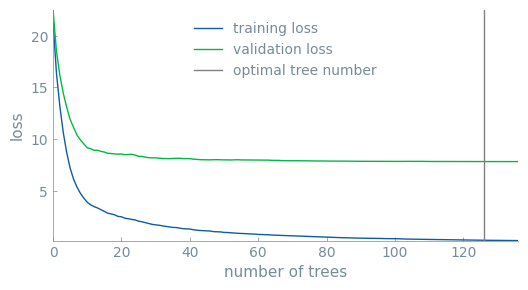

In [36]:
results = reg.evals_result()

plt.figure(figsize=(6, 3))
plt.plot(results["validation_0"]["rmse"], label="training loss")
plt.plot(results["validation_1"]["rmse"], label="validation loss")
plt.axvline(best_iteration, color="gray", label="optimal tree number")
plt.xlabel("number of trees")
plt.ylabel("loss")
plt.legend()

In [37]:
y_pred = reg.predict(X_test)
y_pred

array([ 6.7102847, 42.930595 , 11.859651 , 63.136654 , 84.12237  ,
       11.9095   , 14.317832 , 68.728615 , 24.172127 , 40.593647 ,
       87.70435  , 19.914017 , 46.215084 , 52.179047 , 85.70588  ,
       73.51006  , 14.731393 , 74.69667  , 78.65778  , 14.265269 ,
       44.014095 , 22.137684 , 28.129608 , 55.969887 , 18.66378  ,
       70.5484   , 18.668161 , 84.63422  , 55.177937 ,  7.1138344,
       13.7668085, 21.505733 , 22.387457 , 18.127392 , 48.28456  ,
       67.81546  , 86.453835 , 81.39343  , 70.70571  , 43.67332  ,
       83.78055  , 12.73897  , 79.95096  , 84.189514 , 50.019577 ,
       50.45224  , 28.05318  , 60.10865  , 22.160505 , 27.851252 ,
       18.163885 , 55.485912 , 62.564716 , 27.439611 ,  6.904245 ,
       83.55267  , 16.620495 , 19.712038 , 39.773914 , 81.165405 ,
        9.888132 , 41.849167 , 23.295897 , 41.53988  , 24.21326  ,
       26.532732 , 23.426416 , 83.88925  , 40.064823 , 46.37652  ,
       52.067345 , 68.839745 , 28.895891 , 41.099777 , 86.9031

In [38]:
y_test

array([  7,  44,  13,  60,  72,   8,  16,  72,  32,  27,  93,  19,  40,
        48,  84,  75,  16,  93,  90,  13,  64,  19,  32,  48,  18,  93,
        20,  96,  64,   7,  14,  25,  23,  19,  55,  57,  84,  85,  64,
        40,  96,  13,  90,  98,  71,  48,  32,  54,  27,  32,  18,  64,
        64,  27,   8,  80,  16,  19,  42,  98,  12,  42,  27,  42,  19,
        25,  24,  83,  40,  48,  48,  60,  32,  39,  96,  25, 100,  75,
         6])

In [39]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

In [40]:
r2, mae, rmse

(0.9340648055076599, 5.108090485198589, 7.405649589070992)

In [41]:
def prepare_dataset_regression(
    scattering_patterns, 
    num_atoms, 
    max_test_data=100, 
    THRESHOLD_num = 60, 
    train_size = 250, 
    random_state=42
):
    """
    Prepares the dataset for regression by splitting it into training, validation, and test sets.

    Parameters:
    scattering_patterns (list or numpy.ndarray): The list or array of feature files.
    num_atoms (list or numpy.ndarray): The list or array of target values representing the number of atoms.
    THRESHOLD_num (int): The threshold value to stratify when creating train, validation and test sets.
    train_size (int): The number of samples used for training.

    Returns:
    tuple: A tuple containing:
        - X_train (numpy.ndarray): The training set features.
        - y_train (numpy.ndarray): The training set targets.
        - X_val (numpy.ndarray): The validation set features.
        - y_val (numpy.ndarray): The validation set targets.
        - X_test (numpy.ndarray): The test set features.
        - y_test (numpy.ndarray): The test set targets.
    """
    # Convert scattering_files to a NumPy array
    scattering_patterns = np.array(scattering_patterns)
    # Ensure num_atoms is also a NumPy array
    num_atoms = np.array(num_atoms)
    
    # Create variable to stratify when creating train, validation and test sets
    num_atoms_binned = np.array([1 if value > THRESHOLD_num else 0 for value in num_atoms])
    
    # Split the samples into train and val_test sets
    indices = np.arange(len(num_atoms))
    train_indices, val_test_indices = train_test_split(
        indices, 
        train_size=train_size, 
        test_size=min(len(indices)-train_size, max_test_data),
        random_state=random_state,
        stratify=num_atoms_binned
    )
    y_val_test = num_atoms[val_test_indices]
    
    # Create variable to stratify when creating validation and test sets
    y_val_test_binned = np.array([1 if value > THRESHOLD_num else 0 for value in y_val_test])
    
    # Split the val_test samples equally into validation and test sets
    val_indices, test_indices = train_test_split(
        val_test_indices, 
        test_size=0.5, 
        random_state=random_state,
        stratify=y_val_test_binned
    )
    
    print(f"train: {len(train_indices)}")
    print(f"validation: {len(val_indices)}")
    print(f"test: {len(test_indices)}")
    
    # Create the training, validation, and test sets
    X_train, y_train = scattering_patterns[train_indices], num_atoms[train_indices]
    X_val, y_val = scattering_patterns[val_indices], num_atoms[val_indices]
    X_test, y_test = scattering_patterns[test_indices], num_atoms[test_indices]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [42]:
def train_and_evaluate_regressor(X_train, y_train, X_val, y_val, X_test, y_test, random_state=42):
    """
    Trains an XGBoost regressor and evaluates its performance on a test set.

    Parameters:
    X_train (numpy.ndarray): The training set features.
    y_train (numpy.ndarray): The training set targets.
    X_val (numpy.ndarray): The validation set features.
    y_val (numpy.ndarray): The validation set targets.
    X_test (numpy.ndarray): The test set features.

    Returns:
    regression metrics: r2, MAE and RMSE of the predictions on the test set.
    """
    # Create a regressor
    reg = XGBRegressor(
        n_estimators=500, 
        random_state=random_state, 
        early_stopping_rounds=10, 
        eval_metric='rmse'
    )
    
    # Train the regressor with early stopping
    reg.fit(
        X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        verbose=10
    )
    
    # Predict the test set results
    y_pred = reg.predict(X_test)
    
    y_test = np.array(y_test)
    
    # Calculate regression metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return y_test, y_pred, r2, mae, rmse

In [43]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "mae": mae_scores,
        "rmse": rmse_scores,
        "r2": r2_scores
    }
    return metrics_dict

### training size = 600

In [44]:
train_size = 600
iterations = 10
y_test_all = []
y_pred_all = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [45]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for regression
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_regression(
        scattering_patterns, 
        num_atoms, 
        THRESHOLD_num = 60, 
        train_size = train_size,
        random_state = random_state
    )
    print(f"random_state = {random_state}")

    # Regression of number of atoms
    y_test, y_pred, r2, mae, rmse = train_and_evaluate_regressor(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"R2 for number of atoms regression: {r2}")
    print(f"MAE for number of atoms regression: {mae}")
    print(f"RMSE for number of atoms regression: {rmse}")

-------------Iteration 1/10
train: 600
validation: 50
test: 50
random_state = 42
[0]	validation_0-rmse:21.35532	validation_1-rmse:22.12405
[10]	validation_0-rmse:2.53927	validation_1-rmse:9.23442
[20]	validation_0-rmse:1.12316	validation_1-rmse:8.92969
[30]	validation_0-rmse:0.58247	validation_1-rmse:8.80738
[40]	validation_0-rmse:0.32018	validation_1-rmse:8.76879
[50]	validation_0-rmse:0.18818	validation_1-rmse:8.75708
[60]	validation_0-rmse:0.11753	validation_1-rmse:8.75852
[64]	validation_0-rmse:0.09614	validation_1-rmse:8.76443
R2 for number of atoms regression: 0.7175496220588684
MAE for number of atoms regression: 9.557975463867187
RMSE for number of atoms regression: 13.891465676984664
-------------Iteration 2/10
train: 600
validation: 50
test: 50
random_state = 43
[0]	validation_0-rmse:21.36912	validation_1-rmse:24.21074
[10]	validation_0-rmse:2.83305	validation_1-rmse:12.25852
[20]	validation_0-rmse:1.23710	validation_1-rmse:11.60900
[30]	validation_0-rmse:0.65057	validation_1

In [46]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean R2 for number of atoms regression: {np.mean(r2_scores)} +/- {np.std(r2_scores)}")
print(f"mean MAE for number of atoms regression: {np.mean(mae_scores)} +/- {np.std(mae_scores)}")
print(f"mean RMSE for number of atoms regression: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 600
mean R2 for number of atoms regression: 0.8256335914134979 +/- 0.05631046909673298
mean MAE for number of atoms regression: 8.053121221542359 +/- 0.9672679516858682
mean RMSE for number of atoms regression: 11.460513670271325 +/- 1.6775977610041044


In [47]:
compiled_res_600 = pd.DataFrame(metrics_dict())
compiled_res_600.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,600,"[80, 44, 55, 80, 10, 40, 39, 16, 29, 29, 85, 3...","[73.449234, 45.7243, 40.981964, 80.117065, 9.4...",9.557975,13.891466,0.717550
1,600,"[75, 51, 27, 10, 24, 7, 54, 56, 100, 24, 16, 3...","[76.027596, 49.81898, 39.742313, 10.649302, 26...",7.601818,10.639216,0.830023
2,600,"[85, 7, 84, 16, 50, 57, 64, 7, 84, 18, 60, 43,...","[88.34572, 12.367854, 53.803097, 16.103453, 78...",9.049988,13.957304,0.771678


### training size = 1000

In [48]:
train_size = 1000
iterations = 10
y_test_all = []
y_pred_all = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [49]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for regression
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_regression(
        scattering_patterns, 
        num_atoms, 
        THRESHOLD_num = 60, 
        train_size = train_size,
        random_state = random_state
    )
    print(f"random_state = {random_state}")

    # Regression of number of atoms
    y_test, y_pred, r2, mae, rmse = train_and_evaluate_regressor(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"R2 for number of atoms regression: {r2}")
    print(f"MAE for number of atoms regression: {mae}")
    print(f"RMSE for number of atoms regression: {rmse}")

-------------Iteration 1/10
train: 1000
validation: 50
test: 50
random_state = 42
[0]	validation_0-rmse:21.36774	validation_1-rmse:20.84593
[10]	validation_0-rmse:3.33215	validation_1-rmse:10.80004
[20]	validation_0-rmse:1.76573	validation_1-rmse:10.34225
[30]	validation_0-rmse:1.04948	validation_1-rmse:10.09133
[40]	validation_0-rmse:0.68387	validation_1-rmse:10.01031
[50]	validation_0-rmse:0.48475	validation_1-rmse:9.94703
[60]	validation_0-rmse:0.32251	validation_1-rmse:9.94351
[70]	validation_0-rmse:0.23005	validation_1-rmse:9.93656
[80]	validation_0-rmse:0.16187	validation_1-rmse:9.93253
[82]	validation_0-rmse:0.14613	validation_1-rmse:9.93151
R2 for number of atoms regression: 0.8630897998809814
MAE for number of atoms regression: 7.176940250396728
RMSE for number of atoms regression: 10.285426675129282
-------------Iteration 2/10
train: 1000
validation: 50
test: 50
random_state = 43
[0]	validation_0-rmse:21.05688	validation_1-rmse:23.50200
[10]	validation_0-rmse:3.27724	validati

In [50]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean R2 for number of atoms regression: {np.mean(r2_scores)} +/- {np.std(r2_scores)}")
print(f"mean MAE for number of atoms regression: {np.mean(mae_scores)} +/- {np.std(mae_scores)}")
print(f"mean RMSE for number of atoms regression: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1000
mean R2 for number of atoms regression: 0.8910103082656861 +/- 0.023860440331156363
mean MAE for number of atoms regression: 6.636843369483948 +/- 0.55187160765897
mean RMSE for number of atoms regression: 9.462052691657364 +/- 0.9373098985637573


In [51]:
compiled_res_1000 = pd.DataFrame(metrics_dict())
compiled_res_1000.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,1000,"[83, 12, 55, 96, 36, 36, 36, 40, 25, 43, 96, 4...","[81.77688, 9.269066, 34.79704, 79.171974, 40.5...",7.176940,10.285427,0.863090
1,1000,"[84, 16, 51, 9, 25, 8, 30, 8, 85, 51, 55, 6, 2...","[95.27382, 19.371222, 55.860554, 9.831145, 43....",5.392923,7.700010,0.931335
2,1000,"[85, 13, 72, 43, 36, 57, 100, 23, 100, 19, 16,...","[57.34201, 14.711009, 86.22008, 51.348362, 41....",7.127688,10.478075,0.880408


### training size = 1400

In [52]:
train_size = 1400
iterations = 10
y_test_all = []
y_pred_all = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [53]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for regression
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_regression(
        scattering_patterns, 
        num_atoms, 
        THRESHOLD_num = 60, 
        train_size = train_size,
        random_state = random_state
    )
    print(f"random_state = {random_state}")

    # Regression of number of atoms
    y_test, y_pred, r2, mae, rmse = train_and_evaluate_regressor(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"R2 for number of atoms regression: {r2}")
    print(f"MAE for number of atoms regression: {mae}")
    print(f"RMSE for number of atoms regression: {rmse}")

-------------Iteration 1/10
train: 1400
validation: 50
test: 50
random_state = 42
[0]	validation_0-rmse:21.20761	validation_1-rmse:24.61895
[10]	validation_0-rmse:3.69326	validation_1-rmse:9.34742
[20]	validation_0-rmse:2.14262	validation_1-rmse:8.32381
[30]	validation_0-rmse:1.38291	validation_1-rmse:8.14492
[40]	validation_0-rmse:0.94487	validation_1-rmse:7.99857
[50]	validation_0-rmse:0.71196	validation_1-rmse:7.96940
[57]	validation_0-rmse:0.60847	validation_1-rmse:7.98433
R2 for number of atoms regression: 0.9375901222229004
MAE for number of atoms regression: 5.198322982788086
RMSE for number of atoms regression: 6.9320000536823025
-------------Iteration 2/10
train: 1400
validation: 50
test: 50
random_state = 43
[0]	validation_0-rmse:21.32822	validation_1-rmse:25.02589
[10]	validation_0-rmse:3.83215	validation_1-rmse:10.87876
[20]	validation_0-rmse:2.13305	validation_1-rmse:9.83694
[30]	validation_0-rmse:1.42289	validation_1-rmse:9.48810
[40]	validation_0-rmse:1.01533	validation_

In [54]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean R2 for number of atoms regression: {np.mean(r2_scores)} +/- {np.std(r2_scores)}")
print(f"mean MAE for number of atoms regression: {np.mean(mae_scores)} +/- {np.std(mae_scores)}")
print(f"mean RMSE for number of atoms regression: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1400
mean R2 for number of atoms regression: 0.9281602740287781 +/- 0.014981640059074272
mean MAE for number of atoms regression: 5.7007606506347654 +/- 0.5126805800803814
mean RMSE for number of atoms regression: 7.768171252472044 +/- 0.7243158259451493


In [55]:
compiled_res_1400 = pd.DataFrame(metrics_dict())
compiled_res_1400.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,1400,"[72, 18, 60, 84, 54, 36, 7, 54, 55, 7, 100, 16...","[77.294, 17.784418, 73.57169, 72.571884, 62.32...",5.198323,6.932000,0.937590
1,1400,"[83, 57, 12, 28, 15, 16, 23, 30, 80, 43, 40, 4...","[88.7209, 50.680077, 11.043192, 28.333426, 14....",6.442477,8.496348,0.918681
2,1400,"[96, 48, 83, 8, 24, 55, 96, 6, 83, 50, 32, 14,...","[84.147736, 42.579094, 87.18042, 8.563102, 21....",5.411094,7.550845,0.944745


### training size = 1800

In [56]:
train_size = 1800
iterations = 10
y_test_all = []
y_pred_all = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [57]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for regression
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_regression(
        scattering_patterns, 
        num_atoms, 
        THRESHOLD_num = 60, 
        train_size = train_size,
        random_state = random_state
    )
    print(f"random_state = {random_state}")

    # Regression of number of atoms
    y_test, y_pred, r2, mae, rmse = train_and_evaluate_regressor(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"R2 for number of atoms regression: {r2}")
    print(f"MAE for number of atoms regression: {mae}")
    print(f"RMSE for number of atoms regression: {rmse}")

-------------Iteration 1/10
train: 1800
validation: 50
test: 50
random_state = 42
[0]	validation_0-rmse:21.39609	validation_1-rmse:21.68686
[10]	validation_0-rmse:3.87732	validation_1-rmse:9.30123
[20]	validation_0-rmse:2.46867	validation_1-rmse:8.35851
[30]	validation_0-rmse:1.68779	validation_1-rmse:8.02900
[40]	validation_0-rmse:1.28326	validation_1-rmse:7.97066
[50]	validation_0-rmse:0.95512	validation_1-rmse:7.91146
[54]	validation_0-rmse:0.87056	validation_1-rmse:7.96961
R2 for number of atoms regression: 0.927824854850769
MAE for number of atoms regression: 5.283213396072387
RMSE for number of atoms regression: 8.066364480961981
-------------Iteration 2/10
train: 1800
validation: 50
test: 50
random_state = 43
[0]	validation_0-rmse:21.41061	validation_1-rmse:22.14670
[10]	validation_0-rmse:3.98234	validation_1-rmse:8.89697
[20]	validation_0-rmse:2.59410	validation_1-rmse:7.90146
[30]	validation_0-rmse:1.82071	validation_1-rmse:7.93603
[32]	validation_0-rmse:1.75973	validation_1-r

[60]	validation_0-rmse:0.77128	validation_1-rmse:7.14435
[70]	validation_0-rmse:0.59191	validation_1-rmse:7.04163
[80]	validation_0-rmse:0.48022	validation_1-rmse:7.03543
[86]	validation_0-rmse:0.42731	validation_1-rmse:7.03858
R2 for number of atoms regression: 0.902464747428894
MAE for number of atoms regression: 5.849725399017334
RMSE for number of atoms regression: 8.401501629663548


In [58]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean R2 for number of atoms regression: {np.mean(r2_scores)} +/- {np.std(r2_scores)}")
print(f"mean MAE for number of atoms regression: {np.mean(mae_scores)} +/- {np.std(mae_scores)}")
print(f"mean RMSE for number of atoms regression: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1800
mean R2 for number of atoms regression: 0.9424657344818115 +/- 0.01737577884488584
mean MAE for number of atoms regression: 4.71179543209076 +/- 0.7002047336764254
mean RMSE for number of atoms regression: 6.760742746760475 +/- 1.0710416279211097


In [59]:
compiled_res_1800 = pd.DataFrame(metrics_dict())
compiled_res_1800.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,1800,"[96, 8, 42, 100, 49, 32, 8, 40, 19, 48, 96, 25...","[83.45229, 10.938445, 47.58855, 80.74204, 50.9...",5.283213,8.066364,0.927825
1,1800,"[87, 7, 24, 19, 57, 54, 25, 57, 93, 55, 49, 6,...","[83.10365, 6.594844, 25.43424, 22.713161, 69.9...",4.626295,6.725690,0.948543
2,1800,"[72, 54, 80, 33, 8, 24, 84, 6, 75, 57, 43, 13,...","[72.3025, 53.739857, 92.69604, 37.31721, 8.475...",3.322420,5.087739,0.965579


In [60]:
compiled_res = pd.concat([
    compiled_res_600,
    compiled_res_1000,
    compiled_res_1400,
    compiled_res_1800
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

40


,train_size,y_true,y_pred,mae,rmse,r2
0,600,"[80, 44, 55, 80, 10, 40, 39, 16, 29, 29, 85, 3...","[73.449234, 45.7243, 40.981964, 80.117065, 9.4...",9.557975,13.891466,0.717550
1,600,"[75, 51, 27, 10, 24, 7, 54, 56, 100, 24, 16, 3...","[76.027596, 49.81898, 39.742313, 10.649302, 26...",7.601818,10.639216,0.830023
2,600,"[85, 7, 84, 16, 50, 57, 64, 7, 84, 18, 60, 43,...","[88.34572, 12.367854, 53.803097, 16.103453, 78...",9.049988,13.957304,0.771678
3,600,"[43, 85, 95, 51, 14, 50, 96, 55, 71, 48, 87, 1...","[39.502037, 65.95434, 64.14898, 42.628773, 12....",9.577975,12.740865,0.762205
4,600,"[63, 42, 15, 48, 70, 19, 18, 30, 96, 12, 51, 7...","[73.696556, 56.30934, 14.881603, 41.387383, 79...",7.138367,9.516093,0.887230


In [61]:
compiled_res["y_true"][0]

array([ 80,  44,  55,  80,  10,  40,  39,  16,  29,  29,  85,  36,  56,
        24,  64,  72,  13,  36,  10,  85, 100,  55,  13,  96,  83,  29,
        24,  39,  55,  36,  87,  84,  40,  98,  51,  36,  25,  72,  71,
        51,  50,  16,  33,  40,  57,   8,  93,  33,  64,  32])

In [62]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [63]:
compiled_res["y_true"][0]

[80,
 44,
 55,
 80,
 10,
 40,
 39,
 16,
 29,
 29,
 85,
 36,
 56,
 24,
 64,
 72,
 13,
 36,
 10,
 85,
 100,
 55,
 13,
 96,
 83,
 29,
 24,
 39,
 55,
 36,
 87,
 84,
 40,
 98,
 51,
 36,
 25,
 72,
 71,
 51,
 50,
 16,
 33,
 40,
 57,
 8,
 93,
 33,
 64,
 32]

In [64]:
compiled_res.to_csv("XGBoost_results_regres_num_atoms.csv", sep=",", index=False)

In [65]:
df = pd.read_csv("XGBoost_results_regres_num_atoms.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   train_size  40 non-null     int64  
 1   y_true      40 non-null     object 
 2   y_pred      40 non-null     object 
 3   mae         40 non-null     float64
 4   rmse        40 non-null     float64
 5   r2          40 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ KB


In [66]:
df.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,600,"[80, 44, 55, 80, 10, 40, 39, 16, 29, 29, 85, 3...","[73.449234, 45.7243, 40.981964, 80.117065, 9.4...",9.557975,13.891466,0.717550
1,600,"[75, 51, 27, 10, 24, 7, 54, 56, 100, 24, 16, 3...","[76.027596, 49.81898, 39.742313, 10.649302, 26...",7.601818,10.639216,0.830023
2,600,"[85, 7, 84, 16, 50, 57, 64, 7, 84, 18, 60, 43,...","[88.34572, 12.367854, 53.803097, 16.103453, 78...",9.049988,13.957304,0.771678


In [67]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

mae                 rmse                  r2          
                mean       sem       mean       sem      mean       sem
train_size                                                             
600         8.053121  0.322423  11.460514  0.559199  0.825634  0.018770
1000        6.636843  0.183957   9.462053  0.312437  0.891010  0.007953
1400        5.700761  0.170894   7.768171  0.241439  0.928160  0.004994
1800        4.711795  0.233402   6.760743  0.357014  0.942466  0.005792

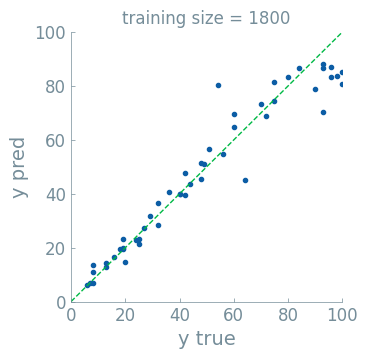

In [68]:
row=30
max_true = max(literal_eval(df.sort_values(['train_size']).iloc[row,1]))
max_pred = max(literal_eval(df.sort_values(['train_size']).iloc[row,2]))
plt.figure(figsize=(3.5, 3.5))
plt.scatter(literal_eval(df.sort_values(['train_size']).iloc[row,1]), 
            literal_eval(df.sort_values(['train_size']).iloc[row,2]),
           color='#0C5DA5')
plt.title(f"training size = {df.sort_values(['train_size']).iloc[row,0]}", fontsize=12)
plt.xlabel('y true', fontsize=14)
plt.ylabel('y pred', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot([0,max(max_true, max_pred)],[0,max(max_true, max_pred)], color='#00B945', linestyle='dashed')
plt.show()